In [1]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.vis import *
from model import PoseModel
from transform import *
from dataset import PlanktonDataset
import cPickle as pickle
from scipy.spatial.distance import euclidean

%matplotlib inline

In [2]:
img_dir = '/data5/Plankton_wi18/rawcolor_db/images'
csv_filename = '/data5/lekevin/plankton/poseprediction/data/data_{}.csv'

phases = ['train', 'valid', 'test']

# dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
normalize = Normalize([0.5, 0.5, 0.5], [1, 1, 1])

batch_size = 16

input_size = (384, 384)

_GPU = 1

In [3]:
data_transform = {
    'train': transforms.Compose([
        Rescale(input_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ])
}

datasets = {x: PlanktonDataset(csv_file=csv_filename.format(x),
                               img_dir=img_dir,
                               transform=data_transform[x])
            for x in phases}

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                             shuffle=False, num_workers=4)
               for x in phases}

dataset_sizes = {x: len(datasets[x]) for x in phases}

use_gpu = torch.cuda.is_available()

In [4]:
model = PoseModel()
model = nn.DataParallel(model)
model = model.cuda()

In [5]:
checkpoints = torch.load('/data3/ludi/plankton_wi17/pose/poseprediction_torch/model_checkpoints_2_26/model_best.pth.tar')
model.load_state_dict(checkpoints['state_dict'])

In [35]:
def evalShowArrow1(image, predcoordinates, gtruthcoordinates, cls):
    if isinstance(image, (np.ndarray, list)):
        image = np.copy(image)
    elif isinstance(image, torch.FloatTensor):
        image = (image.numpy()).transpose((1, 2, 0)).copy()

    if isinstance(gtruthcoordinates, torch.FloatTensor):
        gtruthcoordinates = gtruthcoordinates.numpy()
    
    # Calculate euclidean
    headEuclid = euclidean(predcoordinates[0], np.array([gtruthcoordinates[0],gtruthcoordinates[1]]))
    tailEuclid = euclidean(predcoordinates[1], np.array([gtruthcoordinates[2],gtruthcoordinates[3]]))
    avgEuclid = 0.5*(headEuclid + tailEuclid)
    
    print 'Relative coordinates'
    print 'p(h,t): ',predcoordinates[0], np.array([gtruthcoordinates[0],gtruthcoordinates[1]])
    print 'g(h,t): ',predcoordinates[1], np.array([gtruthcoordinates[2],gtruthcoordinates[3]])
    print "="*40

    height, width = image.shape[:2]
    predhead = (int(predcoordinates[0,0] * width), int(predcoordinates[0,1]*height))
    predtail = (int(predcoordinates[1,0] * width), int(predcoordinates[1,1]*height))

    gtruthhead = (int(gtruthcoordinates[0] * width), int(gtruthcoordinates[1] * height))
    gtruthtail = (int(gtruthcoordinates[2] * width), int(gtruthcoordinates[3] * height))
    
    print 'Original image coordinates'
    print 'p(h,t): ',predhead, predtail
    print 'g(h,t): ',gtruthhead, gtruthtail
    print 'euclid(h,t):', euclidean(predhead, gtruthhead), euclidean(predtail, gtruthtail)
    
    cv2.arrowedLine(image, gtruthtail, gtruthhead, (1., 0., 0.), 3)
    cv2.arrowedLine (image, predtail, predhead, (0., 0., 1.), 3)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Head:{:.03f}\n Tail:{:.03f}\n Avg:{:.03f}'.format(headEuclid, tailEuclid, avgEuclid))
    plt.pause(0.001)

Relative coordinates
p(h,t):  [0.47916667 0.29166667] [0.365      0.31906615]
g(h,t):  [0.4375 0.5625] [0.4675     0.54085603]
Original image coordinates
p(h,t):  (184, 112) (168, 216)
g(h,t):  (140, 122) (179, 207)
euclid(h,t): 45.12205669071391 14.212670403551895


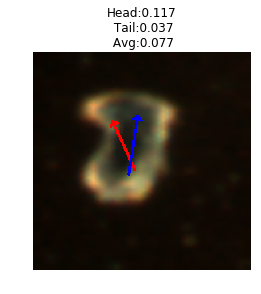

Relative coordinates
p(h,t):  [0.5        0.33333333] [0.435 0.284]
g(h,t):  [0.41666667 0.5       ] [0.48  0.664]
Original image coordinates
p(h,t):  (192, 128) (160, 192)
g(h,t):  (167, 109) (184, 254)
euclid(h,t): 31.400636936215164 66.48308055437865


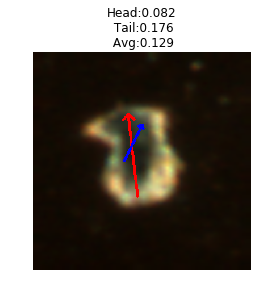

Relative coordinates
p(h,t):  [0.4375     0.27083333] [0.34       0.56179775]
g(h,t):  [0.4375     0.58333333] [0.635      0.42134831]
Original image coordinates
p(h,t):  (168, 104) (168, 224)
g(h,t):  (130, 215) (243, 161)
euclid(h,t): 117.32433677630571 97.94896630388705


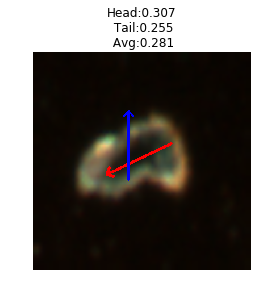

Relative coordinates
p(h,t):  [0.4375 0.25  ] [0.515      0.28909091]
g(h,t):  [0.45833333 0.66666667] [0.445      0.64181818]
Original image coordinates
p(h,t):  (168, 96) (176, 256)
g(h,t):  (197, 111) (170, 246)
euclid(h,t): 32.64965543462902 11.661903789690601


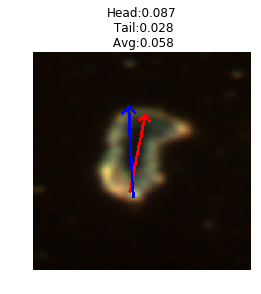

Relative coordinates
p(h,t):  [0.45833333 0.35416667] [0.575      0.61333333]
g(h,t):  [0.5625 0.6875] [0.415      0.31333333]
Original image coordinates
p(h,t):  (176, 136) (216, 264)
g(h,t):  (220, 235) (159, 120)
euclid(h,t): 108.33743581975715 154.8709139896837


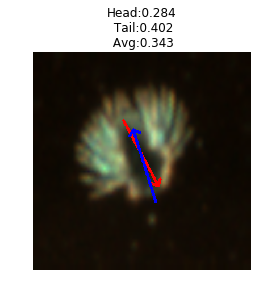

Relative coordinates
p(h,t):  [0.39583333 0.27083333] [0.445      0.25524476]
g(h,t):  [0.5    0.6875] [0.475      0.62587413]
Original image coordinates
p(h,t):  (152, 104) (192, 264)
g(h,t):  (170, 98) (182, 240)
euclid(h,t): 18.973665961010276 26.0


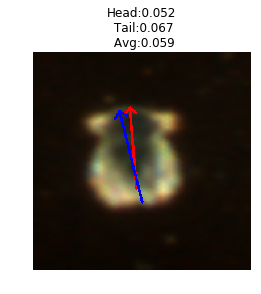

In [57]:
poseCoords = pickle.load(open('predPose.p', "rb"))
poseCoords = [np.fliplr(i) for i in poseCoords]
for j,data in enumerate(dataloaders['test']):
    model.eval()
    inputs, target, coordinates = data['image'], data['target_map'], data['coordinates']
    
#     if use_gpu:
#         inputs = Variable(inputs.cuda(_GPU))
#         target = Variable(target.cuda(_GPU))
#     else:
#         inputs, target = Variable(inputs), Variable(target)
    
#     outputs = model(inputs)
#     pred_maps = outputs.cpu().data[0].numpy()
#     poseCoords = np.stack([np.unravel_index(p.argmax(), p.shape) for p in pred_maps])/48.
    data0 = normalize.recover(data)
    images = data0['image']
    
    fig, axarr = plt.subplots(1,1, figsize=(15,4))
    evalShowArrow1(images[0], poseCoords[j+len(inputs)], coordinates[0], None)
    #evalShowArrow1(images[0], poseCoords[0], coordinates[0], None)

#     for i,pred_map in enumerate(pred_maps):
#         axarr[i+1].imshow(pred_map, cmap='gray')
    if j==5:
        break

In [55]:
poseCoords = pickle.load(open('predPose.p', "rb"))
print poseCoords[0]
poseCoords = [np.fliplr(i) for i in poseCoords]
poseCoords[0]

[[0.20833333 0.41666667]
 [0.66666667 0.33333333]
 [0.         0.97916667]]


array([[0.41666667, 0.20833333],
       [0.33333333, 0.66666667],
       [0.97916667, 0.        ]])

In [ ]:
def get_belief_map(model, image):
    batch_image = image.unsqueeze(0)
    return model(batch_image).data[0]